In [35]:
%load_ext autoreload
%autoreload 2
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
import LikeFitUtils as lfu

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [2]:
# Ok, read in the input data
inputDict = lfu.LoadFromFitsFile("data/draco_srcTemplates.fits")

# Parse out the bits we need
n_obs = inputDict["DATA"]  # This is the actual data
fixed = inputDict["FIXED"]  # This is the sum of the fixed model components
draco = inputDict["DRACO"]
galdif = inputDict["GLL_IEM_V06"]

print "Observed",n_obs.sum()

print "Fixed Model",fixed.sum()
print "Gal.Diff Model",galdif.sum()
print "Draco Model",draco.sum()
print "Gal + Fixed",galdif.sum()+fixed.sum()


Observed 23616.0
Fixed Model 11250.1715835
Gal.Diff Model 12455.3706337
Draco Model 50.0480351941
Gal + Fixed 23705.5422172


Ok, so we have 23616 counts in our ROI, and the best-fit sum of the Galactic diffuse model and all the fixed model components adds up to 23705 counts.

The counts for the Draco model are for a powerlaw spectrum with and index of -2 and an prefactor of $10^{-12} cm^{-2}s^{-1}MeV{-1}$ at 1000 GeV. 

We are going to be fitting for the scale factors of the Draco and Galactic diffuse components with respect to those values.

In [3]:
# Here we make the list of the free models
# the fixed component is handled seperately
modelList = [ draco, galdif ] 
par_index = 0 # This is the index of the source we care about (i.e., Draco)

Ok, now we are going to construct a function that will return the negative log-likelihood for a particular set of normailzation of the draco and Galactic Diffuse flux.

There is utility function to do this in the [LikeFitUtils.py file](./LikeFitUtils.py) in this directory called NLL_func.   In terms of the objects we are using the formula for the negative log-likelihood is:

$-\log\mathcal{L} = \sum_{i} n_{i} \log ( m_{i,\rm{fixed}} + \sum_{j} p_{j} m_{ij} ) - m_{i,\rm{fixed}} - \sum_{j} p_{j} m_{ij}$

Where the index $i$ runs over all the energy bins and pixels, and $j$ run over the model compoents 
* $n_{i}$ are the observed counts: (n_obs)
* $m_{i,\rm{fixed}}$ are the preditcted counts of the fixed model component: (fixed)
* $m_{ij}$ are the predicted counts of the free model components: [draco, galdif]
* $p_{j}$ are the fit parameters: the will be the input to function


In [4]:
help(lfu.NLL_func)

Help on function NLL_func in module LikeFitUtils:

NLL_func(n_obs, fixedModel, freeModels)
    Returns a function that calculates the NLL for a particular set of normalizations
    
    n_obs      : array of the observed counts
    fixedModel : array of the predicted counts for all the fixed model components
    freeModels : list of arrays of the predicted counts for each of the free model components



In [5]:
ftomin = lfu.NLL_func(n_obs,fixed,modelList)
init_pars = np.ones((2))

print "NLL = %.1f"%ftomin(init_pars)

NLL = 50725.0


Ok, now we are going to want to minize the function.   I added a function to LikeFitUtils.py to do this using scipy.optimize.fmin, the function is called Minimize

In [6]:
help(lfu.Minimize)

Help on function Minimize in module LikeFitUtils:

Minimize(ftomin, init_pars)
    Uses scipy.optimize.fmin to minimize the NLL
    
    ftomin     : Function to minimize (basically NLL_func, above)
    init_pars  : array initial values of the fit parameters
    
    returns (fit_pars, nll_min, n_iter, n_calls, status)



In [17]:
# Ok, let's fit the function and parse out the results
result = lfu.Minimize(ftomin,init_pars)
mle_pars = result[0]
mle = mle_pars[par_index]
nll_min = result[1]
nll_null = ftomin([0.,mle_pars[1]])
TS = 2*(nll_null-nll_min)
pvalue = 0.5 # fixme
print "Maximum likelihood estimate = %.1e cm-2 s-1 MeV-1"%(mle*1e-12)
print "Minimum function value = %.2f"%nll_min
print "Test Statistic = %.2f"%TS
print "p-value = %.2f"%pvalue

Maximum likelihood estimate = 1.0e-13 cm-2 s-1 MeV-1
Minimum function value = 50719.40
Test Statistic = 0.47
p-value = 0.50


Ok, so here we have seen that the best-fit value is $1.0^{-13}$cm$^{-2}$s$^{-1}$MeV$^{-1}$, but that the test statistic is only 0.47.  This tells us that we have not significantly detected emission from Draco with a powerlaw index of -2.

##### Question:

Why does $TS = 0.47$ imply a non-detection?

In the absence of a detection, we are now going to derive *upper limits* on the powerlaw prefactor.   To do this are going to have to calculate the likelihood as a function of the Draco flux normalization.  

In [8]:
# Set up a likelihood scan
par_bounds = (1e-2,2.0)
nsteps = 25

# Make a set of input parameter vectors that will serve to do the scan
par_sets = lfu.MakeParSets_1DScan(mle_pars,par_index,par_bounds[0],par_bounds[1],nsteps,log=True)
print par_sets

[[ 0.01        0.99452648]
 [ 0.01247028  0.99452648]
 [ 0.01555079  0.99452648]
 [ 0.01939227  0.99452648]
 [ 0.02418271  0.99452648]
 [ 0.03015652  0.99452648]
 [ 0.03760603  0.99452648]
 [ 0.04689578  0.99452648]
 [ 0.05848035  0.99452648]
 [ 0.07292665  0.99452648]
 [ 0.09094158  0.99452648]
 [ 0.11340671  0.99452648]
 [ 0.14142136  0.99452648]
 [ 0.17635641  0.99452648]
 [ 0.2199214   0.99452648]
 [ 0.27424818  0.99452648]
 [ 0.34199519  0.99452648]
 [ 0.42647762  0.99452648]
 [ 0.53182959  0.99452648]
 [ 0.66320646  0.99452648]
 [ 0.82703711  0.99452648]
 [ 1.03133854  0.99452648]
 [ 1.28610817  0.99452648]
 [ 1.60381306  0.99452648]
 [ 2.          0.99452648]]


Now, we are going to scan likelihood two different ways.  
1. Keeping the normalization of the other parameters fixed
1. Re-optimizing the normalization of the other paramters are each scan step, this is called the profile likelihood.

In [11]:
# This tells us to fix the Draco nomarlization during the Profile likelihood scan
fix_par_mask = np.zeros((2),'?')
fix_par_mask[par_index] = True

In [15]:
pf1 = lfu.ParameterScan(ftomin,par_sets)
print pf1

[ 50719.57816294  50719.5669112   50719.55352353  50719.53779422
  50719.51961663  50719.49906887  50719.47653981  50719.45290746
  50719.42978326  50719.40983632  50719.39721254  50719.39806566
  50719.42122307  50719.47902163  50719.58837056  50719.77213117
  50720.06094865  50720.49572767  50721.13101379  50722.03962776
  50723.31900569  50725.09983125  50727.55771379  50730.92887642
  50735.53107568]


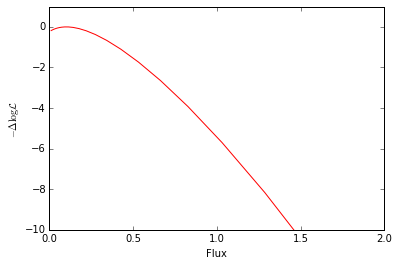

In [24]:
# Let's plot the likelihood, actually what we are going to plot is the 
# delta log-likelihood (w.r.t. the maximum)
fig1,ax1 = lfu.PlotNLLScan(par_sets[0:,par_index],nll_min-pf1)

In our case it doesn't really matter b/c the fit is simple, but it can be useful to interpolate the likelihood between the scan points rather that recompute it.  

In [18]:
interp1 = lfu.BuildInterpolator(par_sets,par_index,pf1)

In [ ]:
pf2 = lfu.ProfileScan(n_obs,par_sets,fix_par_mask,fixed,modelList)

Now we are going to solve for the 95% confidence level upper limits.  In the likelihood ratio test where the test hypothesis has one degree of freedom, and we are at the boundary of that additional degree of freedom this occurs at the point that the log likelihood is 1.35 more that at it's maximum. 

We can derive that factor of 1.35 as follows.

1. Chernoff's theorem states that if the null-hypothesis is correct then 50% of the trials will have TS=0 and the other 50% will be $\chi^2$-distributed with one degree of freedom.
1. *We assign the maximum likelihood estimate as the null-hypothesis.*
1. For 1 degree of freedom the cumulative distribution function of the $\chi^2$-distribution is simply $erf(\sqrt{TS/2})$, and the p-value is complement of that, or $erfc(\sqrt{TS/2})$.
1. Therefore, in our case the p-value as a function x is $p = 0.5 erfc(\sqrt{TS/2})$.
1. Recall that TS is twice the delta log-likelihood, so the TS/2 is simply $\Delta\mathcal{L}$, and $p=0.5 erfc(\sqrt{\Delta\mathcal{L}})$.
1. We can solve numerically for $p=0.05$, or any other confidence level for that matter.
1. For $p=0.05$ we get $\Delta\mathcal{L} = 1.3528$.

Ok, let's solve for the upper limits now.

In [19]:
lim1 = lfu.SolveForErrorLevel(interp1,nll_min,1.35,mle,par_bounds)
print "Simple upper limit %.2e cm-2 s-1 MeV-1"%(lim1*1e-12)

Simple upper limit 4.68e-13 cm-2 s-1 MeV-1


Ok, now let's make a plot of this.

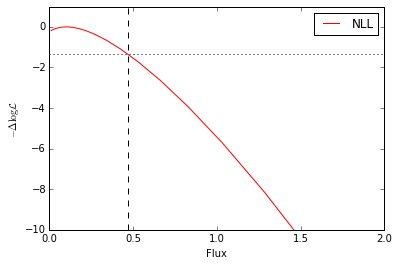

In [22]:
fig2,ax2 = lfu.PlotNLLScan(par_sets[0:,par_index],nll_min-pf1)

ax2.hlines(-1.35,0,2.0,linestyles=u'dotted')
ax2.vlines(lim1,-10,1,linestyles=u'dashed')
    
leg = ax2.legend()

The dashed vertical line indicates the upper limit we have computed: 4.68e-13 cm-2 s-1 MeV-1

#### Profile likelihood

The potential flaw in what we have done is that we didn't allow any of the other paramters to vary as we scanned the log-likelihood as a function of the target flux.  To do things correctly we should at least allow the normalization of the diffuse background to vary to compenstate for the variation in the target flux.

We will do this by re-optimizing the normalization of the other paramters are each scan step, this is called the profile likelihood.

##### Question, how do we expect this to change our results?






In [25]:
help(lfu.ProfileScan)

Help on function ProfileScan in module LikeFitUtils:

ProfileScan(n_obs, par_sets, fix_par_mask, fixedModel, freeModels)
    This calculates the NLL for a series of parameter sets.
    Note that it does re-optimize the parameter, i.e., this
    IS a profile likelihood.   
    
    n_obs      : array of the observed counts
    pars_sets  : an array of n x npar parameters
    fix_par_mask : mask of which parameters to fix, an array(npar,'bool')
    fixedModel : array of the predicted counts for all the fixed model components
    freeModels : list of arrays of the predicted counts for each of the free model components
    
    returns an array(n) of NLL values



In [30]:
pf2 = lfu.ProfileScan(n_obs, par_sets, fix_par_mask, fixed, modelList)
interp2 = lfu.BuildInterpolator(par_sets,par_index,pf2)
lim2 = lfu.SolveForErrorLevel(interp2,nll_min,1.35,mle,par_bounds)
print "Delta Log-Likelihood at 1.0e-12 cm-2 s-1 MeV-1 is %.1f"%(interp2(1.0)-nll_min)
print "Profile upper limit %.2e cm-2 s-1 MeV-1"%(lim2*1e-12)

Delta Log-Likelihood at 1.0e-12 cm-2 s-1 MeV-1 is 5.4
Profile upper limit 4.69e-13 cm-2 s-1 MeV-1


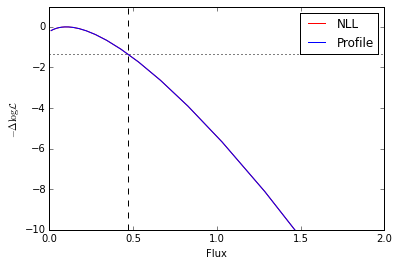

In [34]:
# Ok, let's plot both sets of limits
fig3,ax3 = lfu.PlotNLLScan(par_sets[0:,par_index],nll_min-pf1)
ax3.plot(par_sets[0:,par_index],nll_min-pf2,'b-',label="Profile")

ax3.hlines(-1.35,0,2.0,linestyles=u'dotted')
ax3.vlines(lim1,-10,1,linestyles=u'dashed')
    
leg = ax3.legend()

In the plot we can see several things:

1. The simple scan and the profile scan are virtually indistinguishable.  This isn't too surprising, the Galactic diffuse background template didn't really look anything like the template for Draco.
1. Both curves have a maximum at something like $1.0^{-13}$ cm$^{-2}$ s$^{-1}$ MeV$^{-1}$, since we are ploting the $\Delta\mathcal{L}$ the maximum value is 0.
1. Both curves have a value of around 0.23 for zero Flux, taking twice that value gives us a TS = 0.47.

#####  Question: Is there some way we could have saved ourselves the trouble of doing the profile scan?



#### Comments

At this point we have performed a fit using all of energy bins from 500MeV to 500GeV, and we have tested a powerlaw with index -2 against the data.

In a real dark matter search we have to consider many different spectra.  It would not be appropriate to use the fit results for this spectrum to constrain dark matter models with very different spectra.  

We could imagine redoing the fitting with each different spectra we want to consider, however that is rather tedious.  Instead we would like to make a summary data product showing the flux in each of the energy bins and fit our dark matter spectra to that.

The rest of this class will be about how we do that.


** *[Back to the outline](FermiOverview.ipynb#Lecture-outline)* **